In [64]:
# Definitions

from sage.rings.padics.padic_generic import ResidueLiftingMap
from sage.rings.padics.padic_generic import ResidueReductionMap
import sage.rings.padics.padic_extension_generic

# Basic set-up
p = 2       # Choose the prime p to calculate with
precision = 1014 # Choose the precision that Sage will use

# Define the polynomial to adjoin a root from
Q_p = Qp(p,precision)
R_Qp.<x> = PolynomialRing(Q_p)
f_poly = x^2 +x+1


# Define the p-adic field, its ring of integers and its residue field
# These dummy objects are a workaround to force the precision wanted
dummy1.<Pi> = Zp(p).ext(f_poly)
dummy2.<Pi> = Qp(p).ext(f_poly)

o_L.<Pi> = dummy1.change(prec=precision)
L.<Pi> = dummy2.change(prec=precision)
k_L = L.residue_field()

# Find the generator of the unique maximal ideal in o_L. Needed for the vwdwo sequence
gen_t = o_L.uniformizer()
unique_maximal = o_L.ideal(gen_t)

# find f, e and q
f = k_L.degree()       # The degree of the residual field extension
e = L.degree()/k_L.degree()       # The ramification index
q = p^f

# constructs a lifting map from k_L to o_L to allow us to find representatives for the residue classes
dummy_func = ResidueLiftingMap._create_(k_L, o_L)
def k_L_to_o_L(x):
    return(L(dummy_func(x).lift_to_precision()))

# construct a full set of residues modulo m, the unique maximal ideal of o_L. needed for vwdwo sequence
residues = [k_L_to_o_L(x) for i,x in enumerate(k_L)]

# Do linear algebra over the ring of polynomials L[X] in one variable X with coefficients in the field L:
L_X.<X> = L[]
L_Y.<Y> = L[]

v = L.valuation()

from time import process_time

# Decorator to record execution time
def time_this(func, name=None):
    if name is None:
        name = func.__name__
    
    
    def wrap(*args, **kwargs):
        _start = process_time()
        result = func(*args, **kwargs)
        _end   = process_time()
        
        print(f"{_end-_start : .2f} sec: {name}")
        return result

    return wrap

# The subroutine Dmatrix calculates the following sparse matrix of coefficients.
# Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
# I compute this using the useful and easy recursion formula 
#      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
# that can be derived from Laurent’s Prop 1.20 of "outline9".
# The algorithm is as follows: first make a zero matrix with S rows and columns (roughly, S is (q-1)*Size), 
# then quickly populate it one row at a time, using the recursion formula.

def Dmatrix(S):
    D = matrix(L, S,S)
    D[0,0] = 1
    for k in range(1,S):
        for n in range(k,S):
            r = 0
            while n >= q^r:
                D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                r = r+1
    return D


# \Tau^{(m)} in Definition 10.10 of "bounded21":
def TauMatrix(Size, m):
    D = Dmatrix((q - 1) * (Size + 1))
    R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

    # Define a diagonal matrix:
    Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

    # Compute the inverse of R:
    S = R.inverse()    

    # Compute the matrix Tau using Lemma 10.11 in "bounded21":
    Tau = S * Diag * R
    
    return Tau

def underscore(m, i):
    return m + i*(q-1)

# Compute the matrix ( \sigma_{ij}(Y) ) using Proposition 10.6 of "bounded21":
def sigmaMatrix(Size):
    sigma = matrix(L_Y, Size,Size)
    
    for m in [0 .. q-2]:
        Tau = TauMatrix((q-1)*(Size+1), m)
        j = 0
        while underscore(m, j) < Size:
            i = 0
            while underscore(m, i) < Size:
                sigma[underscore(m, i), underscore(m, j)] = Y^m * Tau[i, j](Y^(q-1))
                i += 1
            j += 1
    
    return sigma

# Construct a vwdwo sequence as per Proposition II.2.3 of Cahen-Chabert:
def vwdwo(N):
    
    #applying the proposition given
    def u(n):
        return o_L(sum(
            residues[n_i] * gen_t^i
            for i, n_i in enumerate(Integer(n).digits(base=q))
        ))
    
    return [u(n) for n in [0 .. N]]

# Compute a regular basis (f_n) as per Theorem II.2.7 of Cahen-Chabert:
def regular_basis(N):
    u = vwdwo(N)
    
    def f(n):
        if n == 0:
            return L_Y(1)
        else:
            return prod((Y - u[k]) / (u[n] - u[k]) for k in [0 .. n-1])
    
    return [f(n) for n in [0 .. N]]


# Find b_i in o_L such that P = \sum b_i f_i:
def regular_basis_coeffs_for(P):
    n = P.degree(Y)
    fs = regular_basis(n)
    u = vwdwo(n)
    bs = [0] * (n + 1)
    for i in [0 .. n]:
        # Since f_i(u_i) = 1; f_j(u_i) = 0 for all j \geq i:
        bs[i] = P(u[i]) - sum(bs[j] * fs[j](u[i]) for j in [0 .. i-1])
    return vector(o_L, bs)

def sigma_coeffs_for_basis(M):
    m = M + 1
    n = (M+2) * (M+1) / 2
    B = Matrix(o_L, m, n)
    
    @time_this
    def compute_sigma():
        return sigmaMatrix(M + 1)
    sigma = compute_sigma()

    @time_this
    def fill_B(B):
        nb_col = 0
        
        for j in [0 .. M]:
            for i in [0 .. j]:
                bs = regular_basis_coeffs_for(sigma[i, j])
                # Only fill in non-zero columns:
                if any(b != 0 for b in bs):                
                    for k, b in enumerate(bs):
                        B[k, nb_col] = b  # Columns of B are the generators
                    nb_col += 1
        
        return B[:, 0:nb_col]
    B = fill_B(B)

    @time_this

    def get_SNF():
        return B.smith_form() 
    A, P, Q = get_SNF()   # A = P B Q

    C = Matrix(L, A[:, 0:M+1])  # A = [C|0]
    
#    return ~P * C  # S_M = o_L . f (~P * A)    
    return ~C * P  # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
                   # where f_n = \sum_{k=0}^M \beta_{k,n} g_k
                   # and g_0, ..., g_M is a basis for the o_L module

        
def sigma_coeffs_for_basis_iter(M):
    depths = Matrix(QQ, M+1, M+1)  # depths[M, j] = w(M, j), defined below
    depths[0, 0] = 0
    
    sigma = time_this(sigmaMatrix)(M + 1)
    m = 0
    P_0 = Q_0 = B = Matrix(o_L, [[1]])
   
    while m < M:
        m += 1
        print()
        print(m)
        
        @time_this
        def fill_B():
            B_new = Matrix(o_L, m+1, binomial(m+2, 2))
            B_new[:m, :B.ncols()] = B
            nb_col = B.ncols()
            for i in [0 .. m]:
                bs = regular_basis_coeffs_for(sigma[i, m])
                if any(b != Integer(0) for b in bs):
                    B_new[:len(bs), nb_col] = bs
                    nb_col += 1
            B_new = B_new[:, :nb_col]
            return nb_col, B_new
        nb_col, B = fill_B()
        
        P_ = block_matrix([ [P_0, 0], [0, identity_matrix(1)] ])  # GL_{m+1}
        Q_ = block_matrix([ [Q_0, 0], [0, identity_matrix(nb_col - Q_0.nrows())] ])  # GL_{nb_col}
        B_ = P_ * B * Q_
        
        A, P, Q = time_this(lambda B: B.smith_form(), f"SNF M={m}")(B_)  # A = P B_ Q = P_ P B Q_ Q

        P_0 = P * P_
        Q_0 = Q_ * Q

        # For each M, compute the vector of valuations (w(M,j), j=0..M), where:
        # w(M,j) is the least non-negative rational number such that p^{w(M,j)} . f_j lies in S_M
        Z = ~(A[:, :m+1]) * P_0
        depths[m, :m+1] = vector([
            -min(v(x) for x in Z[:, j].list()) 
            for j in [0 .. m]
        ])
        print(depths[m, :m+1].list())
    
#     return ~(A[:, :m+1]) * P_0 # nth column is (\beta_{0,n}, ..., \beta_{M,n})^T
    return depths

In [65]:
## Test units

# the valuation v_q, what is the maximal power of q that divides x (only a discrete valuation on Q if q is prime)
def v_q(x):
    if x == 0:
        return "+inf" # this is to represent valuation of 0 ie +inf
    
    i = 0
    
    q_o_L = o_L(q)
    
    while q_o_L.divides(x):
        i = i + 1
        x = o_L(x/q_o_L)
    return i

# the valuation v on o_L, what is the maximal k such that x is in M^k but not in M^(k+1)
# here M is the unique maximal ideal of o_L
def v_m(x):
    if x == 0:
        return "+inf" # this is to represent valuation of 0 ie +inf
    
    i = 0
    
    while x in o_L.ideal(o_L(gen_t^(i+1))):
        i = i + 1
    
    return i

# checks if a sequence is indeed VWDWO by iterating over all possible 1<=i<j<=n
def checkVWDWO(n):
    li = vwdwo(n)
    
    for i in range (0,n):
        for j in range(i,n):
            if v_q(i-j) != v_m(o_L(li[i] - li[j])):
                return False
    
    return True

for i in range(100):
    if not checkVWDWO(i):
        print("oh no")


<IPython.core.display.Javascript object>


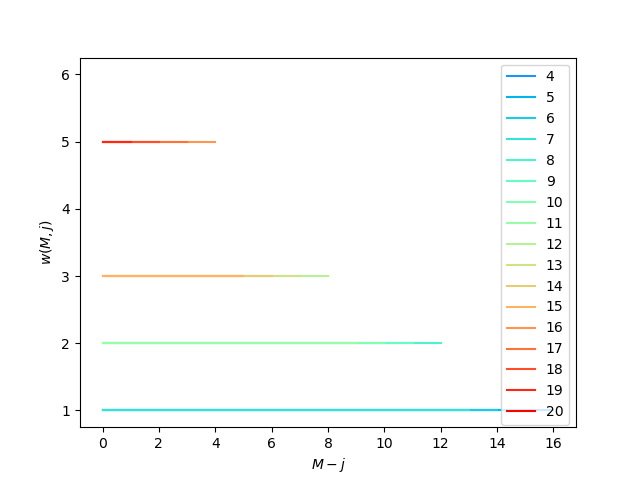

 2.31 sec: sigmaMatrix

1
 0.00 sec: fill_B
 0.00 sec: SNF M=1
[0, 0]

2
 0.00 sec: fill_B
 0.00 sec: SNF M=2
[0, 0, 0]

3
 0.01 sec: fill_B
 0.00 sec: SNF M=3
[0, 0, 0, 0]

4
 0.00 sec: fill_B
 0.00 sec: SNF M=4
[0, 0, 0, 0, 1]

5
 0.00 sec: fill_B
 0.00 sec: SNF M=5
[0, 0, 0, 0, 1, 1]

6
 0.01 sec: fill_B
 0.00 sec: SNF M=6
[0, 0, 0, 0, 1, 1, 1]

7
 0.01 sec: fill_B
 0.00 sec: SNF M=7
[0, 0, 0, 0, 1, 1, 1, 1]

8
 0.01 sec: fill_B
 0.00 sec: SNF M=8
[0, 0, 0, 0, 1, 1, 1, 1, 2]

9
 0.01 sec: fill_B
 0.00 sec: SNF M=9
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2]

10
 0.01 sec: fill_B
 0.00 sec: SNF M=10
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2]

11
 0.01 sec: fill_B
 0.00 sec: SNF M=11
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2]

12
 0.02 sec: fill_B
 0.00 sec: SNF M=12
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3]

13
 0.03 sec: fill_B
 0.01 sec: SNF M=13
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3]

14
 0.03 sec: fill_B
 0.01 sec: SNF M=14
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3]

15
 0.04 sec: fill_B
 0.01 sec: SNF

In [66]:
## Do the calcs

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np

M = 20

plt.figure()
depths = sigma_coeffs_for_basis_iter(M)    
color=iter(cm.rainbow(np.linspace(0, 1, M+1)))
for j in [0 .. M]:
    c=next(color)    
    ws = depths[j:, j].list()
    if ws[0] == 0:
        continue
    if 0 in ws:
        ws = ws[:ws.index(0) + 1]  # crop further zeroes 
    plt.plot(ws, '-', label=f"{j}", c=c)
plt.xlabel("$M - j$")
plt.ylabel("$w(M, j)$")
plt.legend()
plt.show()